In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys

In [2]:
from pathlib import Path
sys.path.insert(0,os.path.abspath('../'))
sys.path.insert(0,os.path.abspath('../utilities'))

In [3]:
import timm

In [4]:
from utilities.utils import *

## ViT on ImageNet

In [5]:
SEED=566
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [6]:
model = timm.create_model('vit_large_patch32_224_in21k',pretrained=False)

In [7]:
LABEL='ViT-ImageNet'
TYPE="RANDOM"

## Getting the hooks for each layers

In [8]:
hookLayersActivationDict = {}
activationDict = {}

In [9]:
modelNamedModules = dict(model.named_modules())

In [10]:
hookLayers = []

for i in modelNamedModules.keys():
    if i.__contains__("norm") or \
        i.__contains__("qkv") or \
        i.__contains__("act") or \
        i.__contains__("proj") or \
        i.__contains__("fc") or \
        i.__contains__("drop_path") :
        hookLayers.append(i)

In [11]:
for layer in hookLayers:
    h = model.get_submodule(layer).register_forward_hook(getActivation(layer,hookLayersActivationDict))

## ImageNet

In [12]:
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
NUM_WORKERS = 0

# normalize = transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
#                                      std=[0.2675, 0.2565, 0.2761])

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# #train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transforms.Compose([
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomCrop(32, 4),
#             transforms.ToTensor(),
#             normalize,
#         ]), download=True)

# train_loader = torch.utils.data.DataLoader(train_dataset,
#         batch_size=TRAIN_BATCH_SIZE, shuffle=True,
#         num_workers=NUM_WORKERS, pin_memory=True)

# val_loader = torch.utils.data.DataLoader(
#         datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
#             transforms.ToTensor(),
#             normalize,
#         ])),
#         batch_size=TEST_BATCH_SIZE, shuffle=False,
#         num_workers=NUM_WORKERS, pin_memory=True)

#valdir = os.path.join(args.data, 'val')
valdir = '/home/abc586/dataset/imagenet/val'
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=TEST_BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model = model.to(device)
valid_acc,activationDict = evaluate(model,device,val_loader,hookLayers,hookLayersActivationDict)

Iteration:   0%|          | 0/782 [00:01<?, ?it/s]


## HSIC calculation and plots

In [15]:
col1,col2,hsicScoreList = getLayerWiseOutputCorrelation(hookLayers,hookLayers,activationDict,activationDict)

In [16]:
import pandas as pd
import seaborn as sns

In [17]:
import matplotlib.ticker as ticker

In [18]:
hsicData = {
    'L1' : col1,
    'L2' : col2,
    'hsic':hsicScoreList
}

hsicDataFrame = pd.DataFrame(data=hsicData)
hsicDataFrame = hsicDataFrame.pivot("L1", "L2", "hsic")

/tmp/ipykernel_1805276/3750928071.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(LABEL+"_"+TYPE+'.pdf',fmt='pdf',bbox_inches='tight')


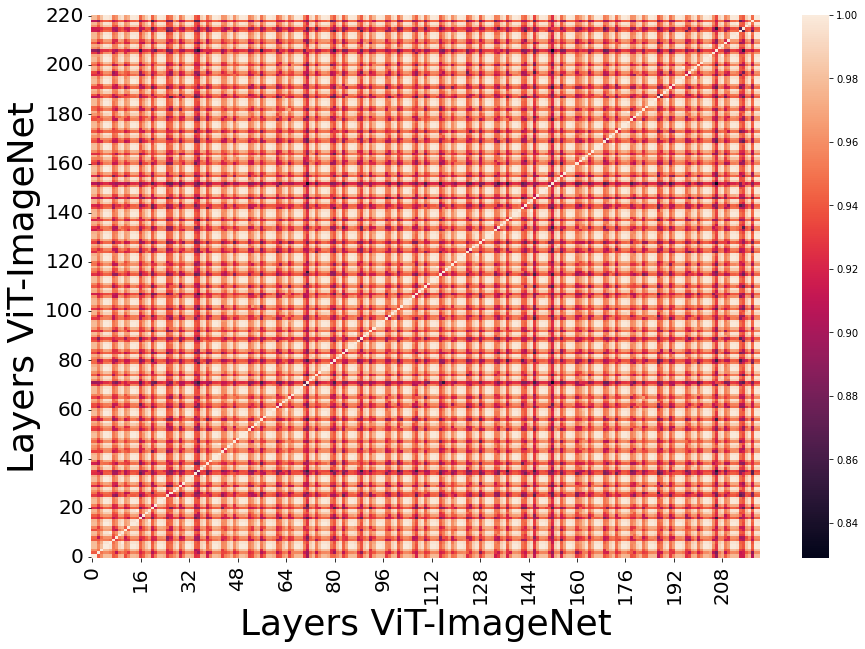

In [19]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(hsicDataFrame.T)
plt.xlabel("Layers "+LABEL,fontsize='36')
plt.ylabel("Layers "+LABEL,fontsize='36')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xticks(ax.get_xticks()[::4])
ax.set_yticks(ax.get_yticks()[::4])
ax.invert_yaxis()
plt.savefig(LABEL+"_"+TYPE+'.pdf',fmt='pdf',bbox_inches='tight')